In [1]:
# ============================================================
# Clears workspace, clones LabelBench, installs dependencies
# ============================================================

!rm -rf /kaggle/working/*
!git clone https://github.com/EfficientTraining/LabelBench.git
!pip install -r /kaggle/working/LabelBench/requirements.txt
%cd /kaggle/working/LabelBench

Cloning into 'LabelBench'...
remote: Enumerating objects: 2858, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 2858 (delta 238), reused 283 (delta 178), pack-reused 2437 (from 1)
Receiving objects: 100% (2858/2858), 111.52 MiB | 32.62 MiB/s, done.
Resolving deltas: 100% (1481/1481), done.
Updating files: 100% (1415/1415), done.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lklsxq5p
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-lklsxq5p
  Resolved https://github.com/openai/CLIP.git to commit ded190a052fdf4585bd685cee5bc96e0310d2c93
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
ls

configs/        LabelBench/  mp_eval_launcher.py  README.md
docs/           LICENSE      mp_launcher.py       requirements.txt
example_run.sh  main.py      point_evaluation.py  results/


## Dataloader setup

In [3]:
import torch
import torch.nn.functional as F
from torchvision import datasets as tv_datasets, transforms
from torch.utils.data import Dataset
from LabelBench.skeleton.dataset_skeleton import register_dataset, LabelType, TransformDataset
import numpy as np

import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

NUM_TASKS = 40   # Total number of incremental tasks


# ------------------------------------------------------------
# Dataset wrapper to expose only a subset of CIFAR-10 indices
# ------------------------------------------------------------
class CIFARStream(Dataset):
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds      # Full CIFAR-10 dataset
        self.indices = indices      # Indices assigned to this task

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Fetch the actual sample using stored indices
        x, y = self.base_ds[self.indices[idx]]
        return x, y


# ------------------------------------------------------------
# One-hot encoding helper (required by LabelBench)
# ------------------------------------------------------------
def one_hot(y, n=10):
    return F.one_hot(torch.tensor(y), num_classes=n).float()


# ------------------------------------------------------------
# Base dataset registry (intentionally disabled)
# ------------------------------------------------------------
@register_dataset("splitcifar10", LabelType.MULTI_CLASS)
def get_splitcifar10(_):
    # Prevent accidental usage of the base dataset
    raise RuntimeError("Use splitcifar10_<id>")


# ------------------------------------------------------------
# Build task stream ONCE (randomized split of CIFAR-10)
# ------------------------------------------------------------
base_train_global = tv_datasets.CIFAR10(root="./data", train=True, download=True)
all_idx = np.arange(len(base_train_global))
# np.random.shuffle(all_idx)
rng = np.random.default_rng(SEED)
rng.shuffle(all_idx)
stream_splits = np.array_split(all_idx, NUM_TASKS)


# ------------------------------------------------------------
# Register each task dynamically
# ------------------------------------------------------------
for split_id in range(NUM_TASKS):

    @register_dataset(f"splitcifar10_{split_id}", LabelType.MULTI_CLASS)
    def _make_split(data_dir, split_id=split_id):

        tf = transforms.Compose([transforms.ToTensor()])

        base_train = tv_datasets.CIFAR10(root=data_dir, train=True, download=True)
        base_test  = tv_datasets.CIFAR10(root=data_dir, train=False, download=True)

        
        # ----------------------------------------------------
        # TASK 0: Base session (only classes 0 and 1)
        # Fully supervised
        # ----------------------------------------------------
        if split_id == 0:
            indices = [i for i,(x,y) in enumerate(base_train) if y in [0,1]]
        else:
            # ------------------------------------------------
            # TASKS 1–19: Unlabeled streaming data
            # ------------------------------------------------
            indices = stream_splits[split_id]

        train_ds = CIFARStream(base_train, indices)

        # Wrap dataset with transforms + one-hot labels
        train_ds = TransformDataset(
            train_ds,
            transform=tf,
            target_transform=lambda y: one_hot(y,10)
        )

        test_ds = TransformDataset(
            base_test,
            transform=tf,
            target_transform=lambda y: one_hot(y,10)
        )

        return train_ds, test_ds, test_ds, None, None, None, 10, [str(i) for i in range(10)]

100%|██████████| 170M/170M [01:39<00:00, 1.71MB/s] 


## DATALOADER CHECKUP FOR UPTO 4 classes myself debugging to check representations

In [4]:
# import torch
# import torch.nn.functional as F
# from torchvision import datasets as tv_datasets, transforms
# from torch.utils.data import Dataset
# from LabelBench.skeleton.dataset_skeleton import register_dataset, LabelType, TransformDataset
# import numpy as np
# from torch.utils.data import Subset


# NUM_TASKS = 40
# num_classes = 4


# # ------------------------------------------------------------
# # Dataset wrapper
# # ------------------------------------------------------------
# class CIFARStream(Dataset):
#     def __init__(self, base_ds, indices):
#         self.base_ds = base_ds
#         self.indices = indices

#     def __len__(self):
#         return len(self.indices)

#     def __getitem__(self, idx):
#         x, y = self.base_ds[self.indices[idx]]
#         return x, y


# # ------------------------------------------------------------
# # One-hot encoding helper
# # ------------------------------------------------------------
# def one_hot(y, n=10):
#     return F.one_hot(torch.tensor(y), num_classes=n).float()


# # ------------------------------------------------------------
# # Base dataset registry (disabled intentionally)
# # ------------------------------------------------------------
# @register_dataset("splitcifar10", LabelType.MULTI_CLASS)
# def get_splitcifar10(_):
#     raise RuntimeError("Use splitcifar10_<id>")


# # ------------------------------------------------------------
# # 🔥 BUILD FILTERED DATASET ONCE (IMPORTANT FIX)
# # ------------------------------------------------------------
# base_train_global = tv_datasets.CIFAR10(
#     root="./data", train=True, download=True
# )

# selected_classes = [0, 1, 2, 3]   # airplane, automobile, bird, cat
# targets_global = np.array(base_train_global.targets)
# filtered_idx_global = np.where(np.isin(targets_global, selected_classes))[0]  #idxs of samples belonging to 0,1,2,3 class

# # Now dataset size is 20000 (4 classes × 5000 each)
# filtered_train_global = Subset(base_train_global, filtered_idx_global) #becomes a new dataset of length 4.

# # Build stream splits FROM FILTERED DATASET
# all_idx = np.arange(len(filtered_train_global))
# np.random.shuffle(all_idx)
# stream_splits = np.array_split(all_idx, NUM_TASKS)


# # ------------------------------------------------------------
# # Register each task dynamically
# # ------------------------------------------------------------
# for split_id in range(NUM_TASKS):

#     @register_dataset(f"splitcifar10_{split_id}", LabelType.MULTI_CLASS)
#     def _make_split(data_dir, split_id=split_id):

#         tf = transforms.Compose([transforms.ToTensor()])

#         # -------------------------
#         # TRAIN DATA (filtered)
#         # -------------------------
#         base_train = tv_datasets.CIFAR10(
#             root=data_dir, train=True, download=True
#         )

#         targets = np.array(base_train.targets)
#         indices = np.where(np.isin(targets, selected_classes))[0]
#         base_train = Subset(base_train, indices)

#         # -------------------------
#         # TEST DATA (filtered)
#         # -------------------------
#         base_test = tv_datasets.CIFAR10(
#             root=data_dir, train=False, download=True
#         )

#         targets = np.array(base_test.targets)
#         indices = np.where(np.isin(targets, selected_classes))[0]
#         base_test = Subset(base_test, indices)

#         # ----------------------------------------------------
#         # TASK 0: Base session (only classes 0 and 1)
#         # ----------------------------------------------------
#         if split_id == 0:
#             indices = [
#                 i for i, (x, y) in enumerate(base_train)
#                 if y in [0, 1]
#             ]
#         else:
#             # Use filtered stream splits (FIXED)
#             indices = stream_splits[split_id]

#         train_ds = CIFARStream(base_train, indices)

#         train_ds = TransformDataset(
#             train_ds,
#             transform=tf,
#             target_transform=lambda y: one_hot(y, num_classes)
#         )

#         test_ds = TransformDataset(
#             base_test,
#             transform=tf,
#             target_transform=lambda y: one_hot(y, num_classes)
#         )

#         return (
#             train_ds,
#             test_ds,
#             test_ds,
#             None,
#             None,
#             None,
#             num_classes,
#             [str(i) for i in range(num_classes)]
#         )

## fixing issues one by one no same class promotion (embedding will be passed to model)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s] 



[TSNE] Before Training (Random Model)
[TSNE] Saved tsne_task_-1.png

================ TASK 0 ================
[TASK 0] Sample distribution:
  airplane: 5000
  automobile: 5000
[TSNE-SUPERVISED] Task 0 Epoch 0
[TSNE-SUPERVISED] Task 0 Epoch 5
[TSNE-SUPERVISED] Task 0 Epoch 10
[TSNE-SUPERVISED] Task 0 Epoch 15
[TSNE-SUPERVISED] Task 0 Epoch 20
[TSNE-SUPERVISED] Task 0 Epoch 25
[INIT] Known classes: {'automobile', 'airplane'}
[TSNE] Saved tsne_task_0.png

================ TASK 1 ================
[TASK 1] Sample distribution:
  airplane: 127
  automobile: 146
  bird: 127
  cat: 132
  deer: 129
  dog: 104
  frog: 121
  horse: 116
  ship: 138
  truck: 110
[METRIC] Known-Class Acc = 0.954
[TSNE] Saved tsne_task_1.png

================ TASK 2 ================
[TASK 2] Sample distribution:
  airplane: 103
  automobile: 125
  bird: 130
  cat: 133
  deer: 141
  dog: 128
  frog: 129
  horse: 124
  ship: 125
  truck: 112
[METRIC] Known-Class Acc = 0.954
[TSNE] Saved tsne_task_2.png

==============

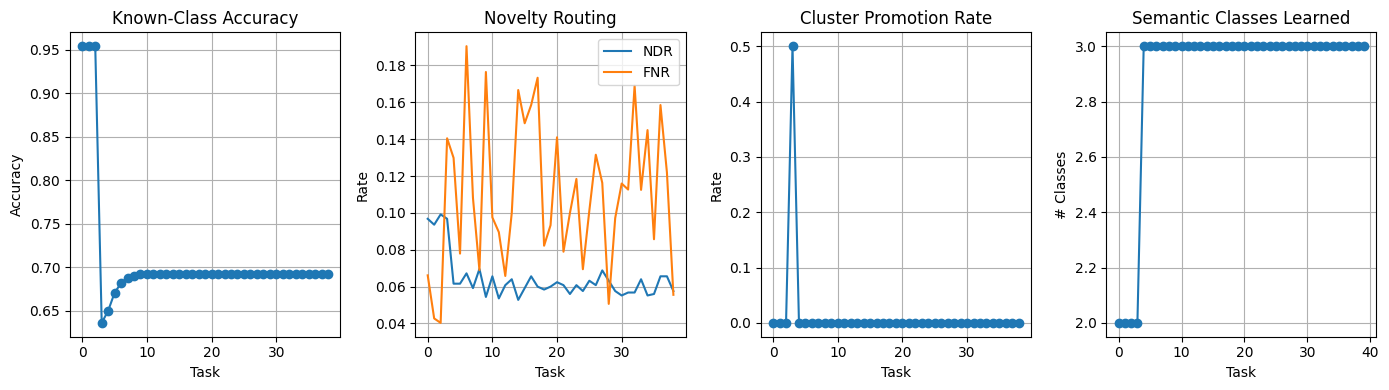

In [5]:
import os
import zipfile

BASE_DIR = "debug_outputs_2"

os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(f"{BASE_DIR}/train_supervised", exist_ok=True)
os.makedirs(f"{BASE_DIR}/finetune", exist_ok=True)
os.makedirs(f"{BASE_DIR}/drift", exist_ok=True)
os.makedirs(f"{BASE_DIR}/hdbscan", exist_ok=True)
os.makedirs(f"{BASE_DIR}/tsne", exist_ok=True)
os.makedirs(f"{BASE_DIR}/tsne_supervised", exist_ok=True)
os.makedirs(f"{BASE_DIR}/tsne_finetune", exist_ok=True)

# ============================================================
# OPEN-WORLD LEARNING WITH CLASS DISCOVERY + METRICS
# ============================================================
# This script implements an open-world continual learning setup:
#
# 1. Train initially on known classes.
# 2. Detect novel samples using hypersphere-based boundaries.
# 3. Accumulate high-novelty samples in a buffer.
# 4. Periodically cluster novel samples.
# 5. Validate clusters using unsupervised criteria.
# 6. Promote valid clusters to new classes.
# 7. Expand classifier head dynamically.
# 8. Fine-tune while replaying old class memory.
# 9. Track multiple evaluation metrics.
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torch.utils.data import DataLoader, TensorDataset
import hdbscan
from torchvision.models import resnet18
from LabelBench.skeleton.dataset_skeleton import datasets as DATASET_REGISTRY
from sklearn.manifold import TSNE

import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

# ============================================================
# CONFIGURATION
# ============================================================

NUM_TASKS = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Cluster validation thresholds
COH_THR = 0.25
SEP_THR = 0.15
P = 4                      # perform clustering every P tasks
TOPK_NOVELTY = 200         # top novel samples per task
MAX_NOVELTY_BUFFER = 500   # maximum buffer size
MIN_CLUSTER_SIZE = 30      # minimum cluster size for promotion

ALPHA = 0.15
BETA = 0.50
DELTA = 120
MIN_CLUSTER_SIZE = 50


# ============================================================
# CIFAR-10 LABEL MAP
# ============================================================

CIFAR10_LABELS = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat",
    4: "deer", 5: "dog", 6: "frog", 7: "horse",
    8: "ship", 9: "truck"
}


# ============================================================
# MODEL DEFINITION
# ============================================================

class CNN(nn.Module):
    """
    Model architecture:
    - Pretrained ResNet18 backbone
    - Final FC layer removed
    - Projection layer (512 → 256)
    - Classifier head (256 → num_classes)
    """

    def __init__(self, num_classes):
        super().__init__()

        base = resnet18(pretrained=True)

        # Remove the final fully connected layer
        self.encoder = nn.Sequential(*list(base.children())[:-1])

        # Projection layer to embedding space
        self.embed = nn.Linear(512, 256)

        # Classification head
        self.classifier = nn.Linear(256, num_classes)

    def expand_head(self, new_classes):
        """
        Expand classifier head while preserving existing weights.
        """

        old_w = self.classifier.weight.data.clone()
        old_b = self.classifier.bias.data.clone()
        old_n = old_w.shape[0]

        # self.classifier = nn.Linear(256, new_classes)
        new_layer = nn.Linear(256, new_classes)
        torch.manual_seed(SEED)
        nn.init.xavier_uniform_(new_layer.weight)
        nn.init.zeros_(new_layer.bias)
        self.classifier = new_layer

        # Copy old class weights
        self.classifier.weight.data[:old_n] = old_w
        self.classifier.bias.data[:old_n] = old_b

    def forward(self, x):

        # Extract deep features
        z = self.encoder(x).squeeze()

        # Project to embedding space
        z = self.embed(z)

        # Normalize embeddings (unit hypersphere)
        z = F.normalize(z, dim=1)

        # Compute logits
        logits = self.classifier(z)

        return logits, z

# ============================================================
# CENTROID TRACKER FOR DRIFT CHECKS (FINETUNING)
# ============================================================
class DebugCentroidTracker:
    def __init__(self):
        self.reference = {}
        self.history = defaultdict(list)

    def snapshot(self, model, memory):
        """
        Store reference centroids (read-only snapshot)
        """
        self.reference = self.compute_centroids(model, memory)

    def compute_centroids(self, model, memory):
        model.eval()
        centroids = {}

        with torch.no_grad():
            for cls, Zs in memory.items():
                Zs = torch.stack(Zs).to(DEVICE)

                # Recompute embeddings through model
                Z_norm = F.normalize(Zs, dim=1)
                mu = F.normalize(Z_norm.mean(0), dim=0)

                centroids[cls] = mu.detach().cpu()

        return centroids

    def measure_drift(self, model, memory, epoch, tag=""):
        current = self.compute_centroids(model, memory)

        for cls in self.reference:
            if cls in current:
                drift = 1 - torch.dot(
                    self.reference[cls],
                    current[cls]
                )

                self.history[(tag, cls)].append(drift.item())

                print(
                    f"[DEBUG-DRIFT {tag}] "
                    f"Epoch {epoch} Class {cls}: {drift:.4f}"
                )
                with open(f"{BASE_DIR}/drift/{tag}.txt", "a") as f: f.write(f"Epoch {epoch} Class {cls}: {drift:.4f}\n")
    
    def plot_drift(self, tag):
        for (t, cls), values in self.history.items():
            if t == tag:
                plt.plot(values, label=f"class {cls}")
        plt.legend()
        plt.title(f"Centroid Drift {tag}")
        plt.xlabel("Checkpoint")
        plt.ylabel("1 - cosine similarity")
        plt.grid(True)
        plt.savefig(f"{BASE_DIR}/drift/{tag}_plot.png")
        plt.close()
        
# ============================================================
# MEMORY BUFFER
# ============================================================

class MemoryBuffer:
    """
    Stores a limited number of representative embeddings
    per known class.
    """

    def __init__(self, max_per_class=80):
        self.data = defaultdict(list)
        self.max_per_class = max_per_class

    def add_batch(self, Z, y):
        """
        Add embeddings for a class and keep only the most central ones.
        """
        for z in Z:
            self.data[int(y)].append(z.detach().cpu())
        self._reduce(y)

    def _reduce(self, y):
        """
        Keep only embeddings closest to the class centroid.
        """
        Z = self.data[int(y)]

        if len(Z) <= self.max_per_class:
            return

        Z = torch.stack(Z)
        mu = F.normalize(Z.mean(0), dim=0)

        # Cosine distance from centroid
        d = 1 - torch.matmul(Z, mu)

        idx = torch.argsort(d)[:self.max_per_class]
        self.data[int(y)] = [Z[i] for i in idx]

    def get(self):
        return self.data


# ============================================================
# HYPERSPHERE NOVELTY DETECTOR
# ============================================================

class HypersphereNovelty:
    """
    Each known class is represented by:
    - A centroid (mean embedding)
    - A radius (quantile of distances)
    """

    def __init__(self, q=0.95):
        self.q = q
        self.mu, self.r = {}, {}

    def update(self, memory):
        """
        Recompute class centroids and radii
        from memory buffer.
        """
        self.mu, self.r = {}, {}

        for k, Z in memory.items():
            Z = torch.stack(Z)
            mu = F.normalize(Z.mean(0), dim=0)
            d = 1 - torch.matmul(Z, mu)

            self.mu[k] = mu
            self.r[k] = torch.quantile(d, self.q)

    def score(self, z):
        """
        Compute novelty score:
        distance from closest class hypersphere boundary.
        """
        return min([
            (1 - torch.dot(z.cpu(), self.mu[k])) - self.r[k]
            for k in self.mu
        ])
        
# ============================================================
# SUPERVISED TRAINING (INITIAL TASK)
# ============================================================
def train_supervised(model, loader, test_loader, task_id):

    opt = torch.optim.Adam(model.parameters(), 1e-4)
    model.train()

    for epoch in range(30):
        #visualize model representations every 5 epochs
        if epoch % 5 == 0:
            visualize_epoch_tsne(model, test_loader, task_id, epoch,
                                known_semantics=set(semantic_to_internal.keys()), phase="supervised")
            
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.argmax(1).to(DEVICE)
            loss = F.cross_entropy(model(x)[0], y)
            opt.zero_grad()
            loss.backward()
            opt.step()
    
# ============================================================
# PROTOTYPE LOSS
# ============================================================
def prototype_loss(z, y, detector):
    """
    Encourages embeddings to stay close to class centroids.
    """
    if len(detector.mu) == 0:
        return torch.tensor(0.0, device=z.device)
    loss = 0.0
    count = 0
    for i in range(len(z)):
        cls = int(y[i].item())
        if cls in detector.mu:
            mu = detector.mu[cls].to(z.device)
            loss += 1 - torch.dot(z[i], mu)
            count += 1
    if count == 0:
        return torch.tensor(0.0, device=z.device)

    return loss / count


# ============================================================
# FINE-TUNING AFTER CLASS PROMOTION
# ============================================================

def finetune(model, memory, Z_new, new_label, detector, task_id, test_loader):
    #for checking centroid shifts (initialisation)
    debug_tracker = DebugCentroidTracker()
    debug_tracker.snapshot(model, memory)
    
    model.train()

    # Freeze all parameters
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze only last ResNet block + embedding + classifier
    for name, p in model.encoder.named_parameters():
        if "layer4" in name:
            p.requires_grad = True

    for p in model.embed.parameters():
        p.requires_grad = True

    for p in model.classifier.parameters():
        p.requires_grad = True

    # Build balanced replay dataset
    X, Y = [], []

    min_count = min(len(v) for v in memory.values())

    for cls, Zs in memory.items():
        for z in Zs[:min_count]:
            X.append(z)
            Y.append(cls)

    for z in Z_new:
        X.append(z.cpu())
        Y.append(new_label)

    X = torch.stack(X).to(DEVICE)
    Y = torch.tensor(Y).to(DEVICE)

    opt = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4
    )
    visualize_epoch_tsne(model, test_loader, task_id, epoch="before", known_semantics=set(semantic_to_internal.keys()),
                         phase="finetune")
    
    FT_EPOCHS = 30
    for epoch in range(FT_EPOCHS):
        X_norm = F.normalize(X, dim=1)
        logits = model.classifier(X_norm)
        loss_ce = F.cross_entropy(logits, Y)
        loss_proto = prototype_loss(X, Y, detector)
        loss = loss_ce + 0.4 * loss_proto
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            filter(lambda p: p.requires_grad, model.parameters()),
            max_norm=5.0
        )
        opt.step()
        
        # Dump representations and check centroid shift every 5 epochs
        if epoch % 5 == 0:
            visualize_epoch_tsne(
                model,
                test_loader,
                task_id,
                epoch,
                known_semantics=set(semantic_to_internal.keys()),
                phase="finetune"
            )
            debug_tracker.measure_drift(model,memory,epoch,tag=f"FT_Task{task_id}")
        
    model.eval()
    return debug_tracker


# ============================================================
# REHEARSAL FOR OLD CLASSES
# ============================================================
def rehearse(model, memory):
    if not memory.get():
        return
    model.train()
    X, Y = [], []
    for cls, Zs in memory.get().items():
        for z in Zs:
            X.append(z)
            Y.append(cls)
    X = torch.stack(X).to(DEVICE)
    Y = torch.tensor(Y).to(DEVICE)
    dataset = TensorDataset(X, Y)
    # loader = DataLoader(dataset, batch_size=128, shuffle=True)
    loader = DataLoader(dataset, batch_size=128, shuffle=True, generator=torch.Generator().manual_seed(SEED))
    opt = torch.optim.Adam(
        list(model.embed.parameters()) +
        list(model.classifier.parameters()),
        lr=5e-4
    )
    for _ in range(30):
        for xb, yb in loader:
            xb_norm = F.normalize(xb, dim=1)
            logits = model.classifier(xb_norm)
            loss = F.cross_entropy(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

def visualize_tsne(model, loader, task_id, known_semantics, tag=""):
    model.eval()
    Z_all, Y_all = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            _, z = model(x)
            y = y.argmax(1)

            # Keep only samples whose semantic label is known
            mask = torch.tensor(
                [int(label.item()) in known_semantics for label in y]
            )

            if mask.sum() == 0:
                continue

            Z_all.append(z[mask].cpu())
            Y_all.append(y[mask].cpu())

    if len(Z_all) == 0:
        print("No known-class samples to visualize.")
        return

    Z_all = torch.cat(Z_all).numpy()
    Y_all = torch.cat(Y_all).numpy()

    # Subsample
    max_points = 3000
    if len(Z_all) > max_points:
        idx = np.random.choice(len(Z_all), max_points, replace=False)
        Z_all = Z_all[idx]
        Y_all = Y_all[idx]

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        metric="cosine",
        random_state=42,
        init="pca"
    )

    Z_2d = tsne.fit_transform(Z_all)

    plt.figure(figsize=(7,6))

    for label in sorted(np.unique(Y_all)):
        mask = Y_all == label
        plt.scatter(
            Z_2d[mask, 0],
            Z_2d[mask, 1],
            s=12,
            alpha=0.6,
            label=CIFAR10_LABELS[int(label)]
        )

    title = f"t-SNE Task {task_id}"
    if tag != "":
        title += f" ({tag})"

    plt.title(title)
    plt.legend(fontsize=8, markerscale=2)
    plt.grid(True)
    plt.tight_layout()

    filename = f"tsne_task_{task_id}"
    if tag != "":
        filename += f"_{tag}"

    # plt.savefig(filename + ".png")
    plt.savefig(f"{BASE_DIR}/tsne/{filename}.png")
    plt.close()

    print(f"[TSNE] Saved {filename}.png")



# ============================================================
# VISUALIZE CLUSTERS
# ============================================================
def visualize_clusters(Z, labels, task_id):
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    Z_2d = tsne.fit_transform(Z)

    plt.figure(figsize=(6,5))

    for cid in set(labels):
        mask = labels == cid
        if cid == -1:
            plt.scatter(Z_2d[mask,0], Z_2d[mask,1], 
                        s=10, alpha=0.3, label="Noise")
        else:
            plt.scatter(Z_2d[mask,0], Z_2d[mask,1], 
                        s=15, alpha=0.7, label=f"Cluster {cid}")

    plt.legend()
    plt.title(f"Cluster Structure Task {task_id}")
    plt.grid(True)
    # plt.savefig(f"clusters_task_{task_id}.png")
    plt.savefig(f"{BASE_DIR}/hdbscan/task_{task_id}.png")
    plt.close()


##EPOCH WISE TSNE 
def visualize_epoch_tsne(
    model,
    test_loader,
    task_id,
    epoch,
    known_semantics,
    phase="supervised"
):
    model.eval()

    Z_all, Y_all = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(DEVICE)
            _, z = model(x)

            y = y.argmax(1)

            mask = torch.tensor(
                [int(label.item()) in known_semantics for label in y]
            )

            if mask.sum() == 0:
                continue

            Z_all.append(z[mask].cpu())
            Y_all.append(y[mask].cpu())

    if len(Z_all) == 0:
        return

    Z_all = torch.cat(Z_all).numpy()
    Y_all = torch.cat(Y_all).numpy()

    max_points = 3000
    if len(Z_all) > max_points:
        idx = np.random.choice(len(Z_all), max_points, replace=False)
        Z_all = Z_all[idx]
        Y_all = Y_all[idx]

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        metric="cosine",
        random_state=42,
        init="pca"
    )

    Z_2d = tsne.fit_transform(Z_all)

    plt.figure(figsize=(7,6))

    for label in sorted(np.unique(Y_all)):
        mask = Y_all == label
        plt.scatter(
            Z_2d[mask, 0],
            Z_2d[mask, 1],
            s=12,
            alpha=0.6,
            label=CIFAR10_LABELS[int(label)]
        )

    plt.title(f"{phase} | Task {task_id} | Epoch {epoch}")
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.tight_layout()

    if phase == "supervised":
        save_path = f"{BASE_DIR}/tsne_supervised/task{task_id}_epoch{epoch}.png"
    else:
        save_path = f"{BASE_DIR}/tsne_finetune/task{task_id}_epoch{epoch}.png"

    plt.savefig(save_path)
    plt.close()

    print(f"[TSNE-{phase.upper()}] Task {task_id} Epoch {epoch}")

# ============================================================
# METRIC STORAGE
# ============================================================

task_kca, task_ndr, task_fnr, task_cpr = [], [], [], []
learned_classes_over_time = []
promoted_classes_log = []


# ============================================================
# MAIN CONTINUAL LEARNING LOOP
# ============================================================

TASKS = [f"splitcifar10_{i}" for i in range(NUM_TASKS)]

model = CNN(num_classes=2).to(DEVICE)
memory = MemoryBuffer()
detector = HypersphereNovelty()
novelty_buffer = []

semantic_to_internal = {0: 0, 1: 1}
internal_to_semantic = {0: 0, 1: 1}
known_classes = 2


# ======================= FIX FOR PRETRAIN TSNE =======================
# Create test_ds once (same as inside tasks)
_, dataset_fn = DATASET_REGISTRY[TASKS[0]]
_, test_ds, *_ = dataset_fn("./data")
# =====================================================================
# ======================= ADDED FOR TSNE =======================
print("\n[TSNE] Before Training (Random Model)")
t=-1
# visualize_tsne(model, DataLoader(test_ds, batch_size=128, shuffle=False), "pretrain")
visualize_tsne(
    model,
    DataLoader(test_ds, batch_size=128, shuffle=False),
    t,
    known_semantics=set(semantic_to_internal.keys())
)

for t, task in enumerate(TASKS):
    print(f"\n================ TASK {t} ================")
    
    _, dataset_fn = DATASET_REGISTRY[task]
    train_ds, test_ds, *_ = dataset_fn("./data")
    loader = DataLoader(train_ds, batch_size=64, shuffle=False)

    #SAMPLE DISTRIBUTIONS     
    label_counter = Counter()
    for _, y in loader:
        y = y.argmax(1)
        label_counter.update(y.tolist())
    print(f"[TASK {t}] Sample distribution:")
    for cls, count in sorted(label_counter.items()):
        print(f"  {CIFAR10_LABELS[cls]}: {count}")

    # Initial supervised training
    if t == 0:
        # train_supervised(model, loader)
        train_supervised(model, loader, DataLoader(test_ds, batch_size=128, shuffle=False), t)
        
        with torch.no_grad():
            for x, y in loader:
                _, z = model(x.to(DEVICE))
                y = y.argmax(1)

                for cls in torch.unique(y):
                    memory.add_batch(z[y == cls], cls.item())

        detector.update(memory.get())

        learned_classes_over_time.append(
            {CIFAR10_LABELS[c] for c in set(y.tolist())}
        )

        print(f"[INIT] Known classes: {learned_classes_over_time[-1]}")
        
        # ======================= ADDED FOR TSNE =======================
        visualize_tsne(
            model,
            DataLoader(test_ds, batch_size=128, shuffle=False),
            t,
            known_semantics=set(semantic_to_internal.keys())
        )
        # ==============================================================
        
        continue

    # Rehearsal for stability
    rehearse(model, memory)
    model.eval()

    novelty_candidates = []
    novel, false_novel, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:

            _, z = model(x.to(DEVICE))
            y = y.argmax(1)

            scores = [detector.score(z[i]) for i in range(len(z))]

            base_thr = np.percentile(scores, 90)
            thr = base_thr + 0.01 * known_classes

            for i in range(len(z)):
                total += 1
                if scores[i] > thr:
                    novelty_candidates.append(
                        (scores[i], z[i].cpu(), y[i].item())
                    )
                    novel += 1

                    if y[i].item() < known_classes:
                        false_novel += 1

    task_ndr.append(novel / max(total, 1))
    task_fnr.append(false_novel / max(novel, 1))

    novelty_candidates.sort(reverse=True, key=lambda x: x[0])

    novelty_buffer.extend([
        (z, y) for _, z, y in novelty_candidates[:TOPK_NOVELTY]
    ])

    novelty_buffer = novelty_buffer[-MAX_NOVELTY_BUFFER:]

    # Periodic clustering
    if t % P == 0:

        # Z = np.stack([z.numpy() for z, _ in novelty_buffer])
        Z = np.stack([z.numpy() for z, _ in novelty_buffer]).astype(np.float64)
        labels = hdbscan.HDBSCAN(
            metric='euclidean',
            min_cluster_size=10,
            algorithm='generic',          # IMPORTANT
            approx_min_span_tree=False,   # IMPORTANT
            gen_min_span_tree=True
        ).fit_predict(Z)
        
        visualize_clusters(Z, labels, t) #HDBSCAN visualisation
        
        new_buffer = []
        found, promoted = 0, 0

        for cid in sorted(set(labels)):

            # if promoted >= 1:
            #     break

            idxs = np.where(labels == cid)[0]

            if cid == -1:
                for i in idxs:
                    new_buffer.append(novelty_buffer[i])
                continue

            found += 1

            Zc = torch.stack([novelty_buffer[i][0] for i in idxs])
            mu = F.normalize(Zc.mean(0), dim=0)

            n = len(idxs)
            S_intra = torch.mean(1 - torch.matmul(Zc, mu))

            if len(detector.mu) > 0:
                S_known = min([
                    1 - torch.dot(mu, detector.mu[k].to(mu.device))
                    for k in detector.mu
                ])
            else:
                S_known = torch.tensor(1.0)

            density = n / (S_intra.item() + 1e-6)
            margin = S_known - S_intra

            labels_true = [novelty_buffer[i][1] for i in idxs]
            dist = Counter(labels_true)
            sem_label, cnt = dist.most_common(1)[0]
            purity = cnt / len(labels_true)

            if sem_label in semantic_to_internal:
                continue

            if (
                S_intra <= ALPHA and
                density >= DELTA and
                S_known >= BETA and
                margin > 0.25 and 
                n >= MIN_CLUSTER_SIZE
            ):

                promoted += 1
                new_label = known_classes

                semantic_to_internal[sem_label] = new_label
                internal_to_semantic[new_label] = sem_label
                known_classes += 1

                model.expand_head(known_classes)
                model.to(DEVICE)

                # finetune(model, memory.get(), Zc, new_label, detector, t)
                debug_tracker = finetune(model,memory.get(),Zc,new_label,detector,t,
                                    DataLoader(test_ds, batch_size=128, shuffle=False))
                memory.add_batch(Zc, new_label)
                debug_tracker.plot_drift(f"FT_Task{t}")
                
                promoted_classes_log.append({
                    "task": t,
                    "semantic": CIFAR10_LABELS[sem_label],
                    "purity": purity
                })

                print(f"PROMOTED → {CIFAR10_LABELS[sem_label]}")
                
                # ======================= ADDED FOR TSNE =======================
                visualize_tsne(
                    model,
                    DataLoader(test_ds, batch_size=128, shuffle=False),
                    t,
                    known_semantics=set(semantic_to_internal.keys())
                )
                # ==============================================================

            else:
                for i in idxs:
                    new_buffer.append(novelty_buffer[i])

        novelty_buffer = new_buffer
        task_cpr.append(promoted / max(found, 1))
        detector.update(memory.get())
    else:
        task_cpr.append(0.0)

    learned_classes_over_time.append(
        set(learned_classes_over_time[-1]) |
        {p["semantic"] for p in promoted_classes_log if p["task"] == t}
    )

    # Known-class accuracy evaluation
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in DataLoader(test_ds, batch_size=128):

            x = x.to(DEVICE)
            y = y.argmax(1).to(DEVICE)

            logits, _ = model(x)
            preds = logits.argmax(1)

            for i in range(len(y)):

                sem = int(y[i])

                if sem in semantic_to_internal:

                    internal_gt = semantic_to_internal[sem]

                    if preds[i].item() == internal_gt:
                        correct += 1

                    total += 1

    acc = correct / max(total, 1)
    task_kca.append(acc)

    print(f"[METRIC] Known-Class Acc = {acc:.3f}")
    # ======================= ADDED FOR TSNE =======================
    # visualize_tsne(model, DataLoader(test_ds, batch_size=128, shuffle=False), t)
    visualize_tsne(
        model,
        DataLoader(test_ds, batch_size=128, shuffle=False),
        t,
        known_semantics=set(semantic_to_internal.keys())
    )    
    # ==============================================================

# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n===== FINAL DISCOVERY SUMMARY =====")
print("Initial classes:", learned_classes_over_time[0])
print("Final learned classes:", learned_classes_over_time[-1])

print("\nPromoted classes timeline:")
for p in promoted_classes_log:
    print(f"Task {p['task']:02d} → {p['semantic']} (purity={p['purity']:.2f})")


# ============================================================
# PLOTS
# ============================================================

plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.plot(task_kca, marker='o')
plt.title("Known-Class Accuracy")
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1,4,2)
plt.plot(task_ndr, label="NDR")
plt.plot(task_fnr, label="FNR")
plt.title("Novelty Routing")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)

plt.subplot(1,4,3)
plt.plot(task_cpr, marker='o')
plt.title("Cluster Promotion Rate")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.grid(True)

plt.subplot(1,4,4)
plt.plot([len(s) for s in learned_classes_over_time], marker='o')
plt.title("Semantic Classes Learned")
plt.xlabel("Task")
plt.ylabel("# Classes")
plt.grid(True)

plt.tight_layout()
plt.show()



In [6]:
zip_filename = "debug_outputs_2.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(BASE_DIR):
        for file in files:
            full_path = os.path.join(root, file)
            zipf.write(full_path,
                       os.path.relpath(full_path, BASE_DIR))

print(f"\nZIP FILE CREATED: {zip_filename}")


ZIP FILE CREATED: debug_outputs_2.zip


In [8]:
# import zipfile
# import glob

# # Find all TSNE images
# tsne_files = glob.glob("tsne_task_*.png")

# # Create zip file
# with zipfile.ZipFile("tsne_discovered_images_sameruntwice.zip", "w") as zipf:
#     for file in tsne_files:
#         zipf.write(file)

# print("Created tsne_all_images.zip")

## raw images memory store

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s] 



[TSNE] Before Training
[TSNE] Saved task_-1.png

================ TASK 0 ================
[TSNE-SUPERVISED] Task 0 Epoch 0
[TSNE-SUPERVISED] Task 0 Epoch 5
[TSNE-SUPERVISED] Task 0 Epoch 10
[TSNE-SUPERVISED] Task 0 Epoch 15
[TSNE-SUPERVISED] Task 0 Epoch 20
[TSNE-SUPERVISED] Task 0 Epoch 25
[TSNE] Saved task_0.png
[INIT] Known classes: {'airplane', 'automobile'}

================ TASK 1 ================
[METRIC] Known-Class Acc = 0.950
[TSNE] Saved task_1.png

================ TASK 2 ================
[METRIC] Known-Class Acc = 0.956
[TSNE] Saved task_2.png

================ TASK 3 ================
[METRIC] Known-Class Acc = 0.955
[TSNE] Saved task_3.png

================ TASK 4 ================
Cluster stats → n=251, S_intra=0.032, S_known=0.018, density=7745.4
Cluster stats → n=99, S_intra=0.056, S_known=0.064, density=1772.4
[METRIC] Known-Class Acc = 0.958
[TSNE] Saved task_4.png

================ TASK 5 ================
[METRIC] Known-Class Acc = 0.956
[TSNE] Saved task_5.png

===

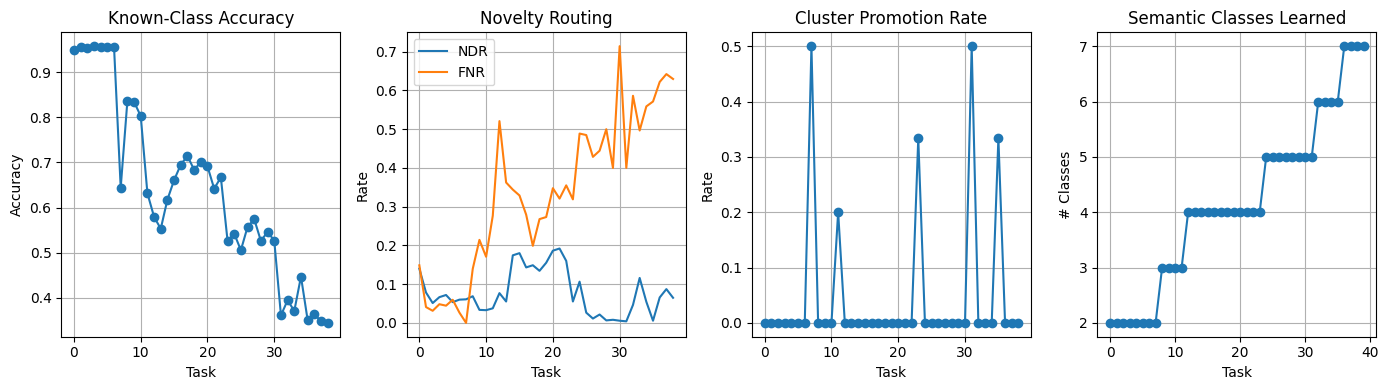

In [11]:
import os
from sklearn.manifold import TSNE
BASE_DIR = "debug_raw_memory"

os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(f"{BASE_DIR}/tsne", exist_ok=True)
os.makedirs(f"{BASE_DIR}/tsne_supervised", exist_ok=True)
os.makedirs(f"{BASE_DIR}/tsne_finetune", exist_ok=True)
os.makedirs(f"{BASE_DIR}/hdbscan", exist_ok=True)
os.makedirs(f"{BASE_DIR}/drift", exist_ok=True)

# ============================================================
# OPEN-WORLD LEARNING WITH CLASS DISCOVERY + METRICS
# ============================================================
# This implementation performs open-world continual learning:
#
# 1. Train initially on known classes.
# 2. Store raw images in memory for replay.
# 3. Use hypersphere-based novelty detection in embedding space.
# 4. Accumulate high-novelty samples.
# 5. Periodically cluster novel samples using HDBSCAN.
# 6. Validate clusters using unsupervised geometric criteria.
# 7. Promote valid clusters to new classes.
# 8. Expand classifier head dynamically.
# 9. Fine-tune model using full replay + prototype regularization.
# 10. Track discovery and accuracy metrics across tasks.
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torch.utils.data import DataLoader
import hdbscan
from torchvision.models import resnet18
from LabelBench.skeleton.dataset_skeleton import datasets as DATASET_REGISTRY


# ============================================================
# CONFIGURATION
# ============================================================

NUM_TASKS = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

COH_THR = 0.25
SEP_THR = 0.15
P = 4                          # Perform clustering every P tasks
TOPK_NOVELTY = 120             # Keep top novel samples per task
MAX_NOVELTY_BUFFER = 500       # Maximum buffer size
MIN_CLUSTER_SIZE = 50          # Initial definition (overridden below)

# Updated cluster validation thresholds
ALPHA = 0.08
BETA = 0.02
DELTA = 40
MIN_CLUSTER_SIZE = 30



# ============================================================
# CIFAR-10 LABEL MAP
# ============================================================

CIFAR10_LABELS = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat",
    4: "deer", 5: "dog", 6: "frog", 7: "horse",
    8: "ship", 9: "truck"
}


# ============================================================
# MODEL DEFINITION
# ============================================================

class CNN(nn.Module):
    """
    Architecture:
    - Pretrained ResNet18 backbone
    - Remove final fully connected layer
    - Projection layer (512 → 256)
    - Normalized embedding
    - Classification head
    """

    def __init__(self, num_classes):
        super().__init__()

        base = resnet18(pretrained=True)

        # Remove final fully connected layer
        self.encoder = nn.Sequential(*list(base.children())[:-1])

        # Projection layer to embedding space
        self.embed = nn.Linear(512, 256)

        # Classifier head
        self.classifier = nn.Linear(256, num_classes)

    def expand_head(self, new_classes):
        """
        Expand classifier head while preserving learned weights.
        """

        old_w = self.classifier.weight.data.clone()
        old_b = self.classifier.bias.data.clone()
        old_n = old_w.shape[0]

        self.classifier = nn.Linear(256, new_classes)

        self.classifier.weight.data[:old_n] = old_w
        self.classifier.bias.data[:old_n] = old_b

    def forward(self, x):

        # Extract deep features
        z = self.encoder(x)

        # Preserve batch dimension
        z = z.view(z.size(0), -1)

        # Project to embedding space
        z = self.embed(z)

        # Normalize embeddings
        z = F.normalize(z, dim=1)

        # Compute class logits
        logits = self.classifier(z)

        return logits, z




# ============================================================
# CENTROID DRIFT TRACKER (RAW IMAGE MEMORY VERSION)
# ============================================================

class DebugCentroidTracker:
    def __init__(self):
        self.reference = {}
        self.history = defaultdict(list)

    def compute_centroids(self, model, memory):
        model.eval()
        centroids = {}

        with torch.no_grad():
            for cls, Xs in memory.items():
                X = torch.stack(Xs).to(DEVICE)
                _, Z = model(X)

                mu = F.normalize(Z.mean(0), dim=0)
                centroids[cls] = mu.detach().cpu()

        return centroids

    def snapshot(self, model, memory):
        self.reference = self.compute_centroids(model, memory)

    def measure_drift(self, model, memory, epoch, tag=""):
        current = self.compute_centroids(model, memory)

        for cls in self.reference:
            if cls in current:
                drift = 1 - torch.dot(
                    self.reference[cls],
                    current[cls]
                )

                self.history[(tag, cls)].append(drift.item())
                print(
                    f"[DEBUG-DRIFT {tag}] "
                    f"Epoch {epoch} Class {cls}: {drift:.4f}"
                )
                with open(f"{BASE_DIR}/drift/{tag}.txt", "a") as f:
                    f.write(f"Epoch {epoch} Class {cls}: {drift:.4f}\n")

    def plot_drift(self, tag):
        for (t, cls), values in self.history.items():
            if t == tag:
                plt.plot(values, label=f"class {cls}")

        plt.legend()
        plt.title(f"Centroid Drift {tag}")
        plt.xlabel("Checkpoint")
        plt.ylabel("1 - cosine similarity")
        plt.grid(True)
        plt.savefig(f"{BASE_DIR}/drift/{tag}_plot.png")
        plt.close()

# ============================================================
# MEMORY BUFFER (Stores RAW IMAGES)
# ============================================================

class MemoryBuffer:
    """
    Stores raw images per class for replay.
    """

    def __init__(self, max_per_class=80):
        self.data = defaultdict(list)
        self.max_per_class = max_per_class

    def add_batch(self, X, y):
        """
        Add raw images for a specific class.
        """
        for x in X:
            self.data[int(y)].append(x.detach().cpu())

        # Keep only limited samples per class
        if len(self.data[int(y)]) > self.max_per_class:
            self.data[int(y)] = self.data[int(y)][:self.max_per_class]

    def get(self):
        return self.data


# ============================================================
# HYPERSPHERE NOVELTY DETECTOR
# ============================================================

class HypersphereNovelty:
    """
    Each class is represented by:
    - Centroid in embedding space
    - Radius determined by quantile distance
    """

    def __init__(self, q=0.90):
        self.q = q
        self.mu, self.r = {}, {}

    def update(self, memory, model):
        """
        Recompute centroids and radii using live embeddings.
        """

        self.mu, self.r = {}, {}

        for k, X in memory.items():

            X = torch.stack(X).to(DEVICE)

            with torch.no_grad():
                _, Z = model(X)

            mu = F.normalize(Z.mean(0), dim=0)
            d = 1 - torch.matmul(Z, mu)

            self.mu[k] = mu
            self.r[k] = torch.quantile(d, self.q)

    def score(self, z):
        """
        Novelty score based on distance from nearest hypersphere boundary.
        """

        return min([
            (1 - torch.dot(z, self.mu[k].to(z.device)))
            - self.r[k].to(z.device)
            for k in self.mu
        ])


# ============================================================
# INITIAL SUPERVISED TRAINING
# ============================================================

def train_supervised(model, loader, test_loader, task_id):
    opt = torch.optim.Adam(model.parameters(), 1e-4)
    model.train()
    for epoch in range(30):
        if epoch % 5 == 0:
            visualize_epoch_tsne(
                model,
                test_loader,
                task_id,
                epoch,
                known_semantics=set(semantic_to_internal.keys()),
                phase="supervised"
            )

        for x, y in loader:
            x = x.to(DEVICE)
            y = y.argmax(1).to(DEVICE)

            loss = F.cross_entropy(model(x)[0], y)
            opt.zero_grad()
            loss.backward()
            opt.step()


# ============================================================
# PROTOTYPE REGULARIZATION LOSS
# ============================================================

def prototype_loss(z, y, detector):

    if len(detector.mu) == 0:
        return torch.tensor(0.0, device=z.device)

    loss = 0.0
    count = 0

    for i in range(len(z)):
        cls = int(y[i].item())

        if cls in detector.mu:
            mu = detector.mu[cls].to(z.device)
            loss += 1 - torch.dot(z[i], mu)
            count += 1

    if count == 0:
        return torch.tensor(0.0, device=z.device)

    return loss / count


# ============================================================
# FINETUNING AFTER CLASS PROMOTION
# ============================================================

def finetune(model, memory, X_new, new_label, detector, task_id, test_loader):
    debug_tracker = DebugCentroidTracker()
    debug_tracker.snapshot(model, memory)
    model.train()

    for p in model.parameters():
        p.requires_grad = True

    X_all, Y_all = [], []

    min_count = min(len(v) for v in memory.values())

    for cls, Xs in memory.items():
        for x in Xs[:min_count]:
            X_all.append(x)
            Y_all.append(cls)

    for x in X_new:
        X_all.append(x.cpu())
        Y_all.append(new_label)

    X_all = torch.stack(X_all).to(DEVICE)
    Y_all = torch.tensor(Y_all).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    # BEFORE FINETUNE SNAPSHOT
    visualize_epoch_tsne(
        model,
        test_loader,
        task_id,
        epoch="before",
        known_semantics=set(semantic_to_internal.keys()),
        phase="finetune"
    )
    for epoch in range(30):
        logits, Z = model(X_all)
        loss_ce = F.cross_entropy(logits, Y_all)
        loss_proto = prototype_loss(Z, Y_all, detector)
        loss = loss_ce + 0.5 * loss_proto
        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch % 5 == 0:
            visualize_epoch_tsne(
                model,
                test_loader,
                task_id,
                epoch,
                known_semantics=set(semantic_to_internal.keys()),
                phase="finetune"
            )
    
            debug_tracker.measure_drift(
                model, memory, epoch,
                tag=f"FT_Task{task_id}"
            )
    model.eval()
    return debug_tracker

# ============================================================
# REHEARSAL FOR STABILITY
# ============================================================

def rehearse(model, memory):

    if not memory.get():
        return

    model.train()

    X_all, Y_all = [], []

    for cls, Xs in memory.get().items():
        for x in Xs:
            X_all.append(x)
            Y_all.append(cls)

    X_all = torch.stack(X_all).to(DEVICE)
    Y_all = torch.tensor(Y_all).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=5e-4)

    for _ in range(20):

        logits, _ = model(X_all)
        loss = F.cross_entropy(logits, Y_all)

        opt.zero_grad()
        loss.backward()
        opt.step()

# ============================================================
# TSNE VISUALISATION PER TASK
# ============================================================
def visualize_tsne(model, loader, task_id, known_semantics, tag=""):

    model.eval()
    Z_all, Y_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            _, z = model(x)

            y = y.argmax(1)

            mask = torch.tensor(
                [int(label.item()) in known_semantics for label in y]
            )

            if mask.sum() == 0:
                continue

            Z_all.append(z[mask].cpu())
            Y_all.append(y[mask].cpu())

    if len(Z_all) == 0:
        return

    Z_all = torch.cat(Z_all).numpy()
    Y_all = torch.cat(Y_all).numpy()

    if len(Z_all) > 3000:
        idx = np.random.choice(len(Z_all), 3000, replace=False)
        Z_all = Z_all[idx]
        Y_all = Y_all[idx]

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        metric="cosine",
        random_state=42,
        init="pca"
    )

    Z_2d = tsne.fit_transform(Z_all)

    plt.figure(figsize=(7,6))

    for label in sorted(np.unique(Y_all)):
        mask = Y_all == label
        plt.scatter(
            Z_2d[mask, 0],
            Z_2d[mask, 1],
            s=12,
            alpha=0.6,
            label=CIFAR10_LABELS[int(label)]
        )

    title = f"Task {task_id}"
    if tag:
        title += f" ({tag})"

    plt.title(title)
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.tight_layout()

    filename = f"task_{task_id}"
    if tag:
        filename += f"_{tag}"

    plt.savefig(f"{BASE_DIR}/tsne/{filename}.png")
    plt.close()

    print(f"[TSNE] Saved {filename}.png")


# ============================================================
# EPOCH WISE TSNE
# ============================================================
def visualize_epoch_tsne(
    model,
    test_loader,
    task_id,
    epoch,
    known_semantics,
    phase="supervised"
):
    model.eval()
    Z_all, Y_all = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(DEVICE)
            _, z = model(x)

            y = y.argmax(1)

            mask = torch.tensor(
                [int(label.item()) in known_semantics for label in y]
            )

            if mask.sum() == 0:
                continue

            Z_all.append(z[mask].cpu())
            Y_all.append(y[mask].cpu())

    if len(Z_all) == 0:
        return

    Z_all = torch.cat(Z_all).numpy()
    Y_all = torch.cat(Y_all).numpy()

    if len(Z_all) > 3000:
        idx = np.random.choice(len(Z_all), 3000, replace=False)
        Z_all = Z_all[idx]
        Y_all = Y_all[idx]

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        metric="cosine",
        random_state=42,
        init="pca"
    )

    Z_2d = tsne.fit_transform(Z_all)

    plt.figure(figsize=(7,6))

    for label in sorted(np.unique(Y_all)):
        mask = Y_all == label
        plt.scatter(
            Z_2d[mask, 0],
            Z_2d[mask, 1],
            s=12,
            alpha=0.6,
            label=CIFAR10_LABELS[int(label)]
        )

    plt.title(f"{phase} | Task {task_id} | Epoch {epoch}")
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.tight_layout()

    if phase == "supervised":
        save_path = f"{BASE_DIR}/tsne_supervised/task{task_id}_epoch{epoch}.png"
    else:
        save_path = f"{BASE_DIR}/tsne_finetune/task{task_id}_epoch{epoch}.png"

    plt.savefig(save_path)
    plt.close()

    print(f"[TSNE-{phase.upper()}] Task {task_id} Epoch {epoch}")

# ============================================================
# HDBSCAN CLUSTERS VISUALISATION
# ============================================================
def visualize_clusters(Z, labels, task_id):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    Z_2d = tsne.fit_transform(Z)

    plt.figure(figsize=(6,5))

    for cid in set(labels):
        mask = labels == cid
        if cid == -1:
            plt.scatter(Z_2d[mask,0], Z_2d[mask,1],
                        s=10, alpha=0.3, label="Noise")
        else:
            plt.scatter(Z_2d[mask,0], Z_2d[mask,1],
                        s=15, alpha=0.7, label=f"Cluster {cid}")

    plt.legend()
    plt.title(f"Cluster Structure Task {task_id}")
    plt.grid(True)
    plt.savefig(f"{BASE_DIR}/hdbscan/task_{task_id}.png")
    plt.close()

# ============================================================
# METRIC STORAGE
# ============================================================

task_kca, task_ndr, task_fnr, task_cpr = [], [], [], []
learned_classes_over_time = []
promoted_classes_log = []


# ============================================================
# MAIN CONTINUAL LEARNING LOOP
# ============================================================

TASKS = [f"splitcifar10_{i}" for i in range(NUM_TASKS)]

model = CNN(num_classes=2).to(DEVICE)
memory = MemoryBuffer()
detector = HypersphereNovelty()

novelty_buffer = []

semantic_to_internal = {0: 0, 1: 1}
internal_to_semantic = {0: 0, 1: 1}
known_classes = 2


_, dataset_fn = DATASET_REGISTRY[TASKS[0]]
_, test_ds, *_ = dataset_fn("./data")
print("\n[TSNE] Before Training")
visualize_tsne(
    model,
    DataLoader(test_ds, batch_size=128, shuffle=False),
    -1,
    known_semantics=set(semantic_to_internal.keys())
)

for t, task in enumerate(TASKS):

    print(f"\n================ TASK {t} ================")

    _, dataset_fn = DATASET_REGISTRY[task]
    train_ds, test_ds, *_ = dataset_fn("./data")
    loader = DataLoader(train_ds, batch_size=64, shuffle=False)

    # Initial supervised training
    if t == 0:

        train_supervised(model,loader,DataLoader(test_ds, batch_size=128, shuffle=False),t)

        with torch.no_grad():
            for x, y in loader:
                y = y.argmax(1)
                for cls in torch.unique(y):
                    memory.add_batch(x[y == cls], cls.item())

        detector.update(memory.get(), model)
        visualize_tsne(
            model,
            DataLoader(test_ds, batch_size=128, shuffle=False),
            t,
            known_semantics=set(semantic_to_internal.keys())
        )
        learned_classes_over_time.append(
            {CIFAR10_LABELS[c] for c in set(y.tolist())}
        )

        print(f"[INIT] Known classes: {learned_classes_over_time[-1]}")
        continue

    rehearse(model, memory)
    model.eval()

    novelty_candidates = []
    novel, false_novel, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:

            _, z = model(x.to(DEVICE))
            y = y.argmax(1)

            scores = [detector.score(z[i]).item() for i in range(len(z))]

            # base_thr = np.percentile(scores, 90)
            base_thr = np.percentile(scores, 80)
            thr = base_thr + 0.01 * known_classes

            for i in range(len(z)):
                total += 1
                if scores[i] > thr:
                    novelty_candidates.append(
                        (scores[i], x[i].cpu(), y[i].item())
                    )
                    novel += 1
                    if y[i].item() < known_classes:
                        false_novel += 1

    task_ndr.append(novel / max(total, 1))
    task_fnr.append(false_novel / max(novel, 1))

    novelty_candidates.sort(reverse=True, key=lambda x: x[0])

    novelty_buffer.extend([
        (img, y) for _, img, y in novelty_candidates[:TOPK_NOVELTY]
    ])

    novelty_buffer = novelty_buffer[-MAX_NOVELTY_BUFFER:]

    # Periodic clustering
    if t % P == 0:

        Z = []

        with torch.no_grad():
            for img, _ in novelty_buffer:
                _, z = model(img.unsqueeze(0).to(DEVICE))
                Z.append(z.squeeze().cpu().numpy())

        Z = np.stack(Z)

        labels = hdbscan.HDBSCAN(
            metric='euclidean',
            min_cluster_size=10
        ).fit_predict(Z)
        
        visualize_clusters(Z, labels, t)
        
        new_buffer = []
        found, promoted = 0, 0

        for cid in sorted(set(labels)):

            idxs = np.where(labels == cid)[0]

            if cid == -1:
                for i in idxs:
                    new_buffer.append(novelty_buffer[i])
                continue

            found += 1

            Xc = torch.stack([novelty_buffer[i][0] for i in idxs])

            with torch.no_grad():
                _, Zc = model(Xc.to(DEVICE))

            mu = F.normalize(Zc.mean(0), dim=0)
            n = len(idxs)
            S_intra = torch.mean(1 - torch.matmul(Zc, mu))

            if len(detector.mu) > 0:
                S_known = min([
                    1 - torch.dot(mu, detector.mu[k].to(mu.device))
                    for k in detector.mu
                ])
            else:
                S_known = torch.tensor(1.0)

            density = n / (S_intra.item() + 1e-6)
            margin = S_known - S_intra
            labels_true = [novelty_buffer[i][1] for i in idxs]
            sem_label, cnt = Counter(labels_true).most_common(1)[0]
            purity = cnt / len(labels_true)

            if sem_label in semantic_to_internal:
                continue

            print(
                f"Cluster stats → "
                f"n={n}, "
                f"S_intra={S_intra.item():.3f}, "
                f"S_known={S_known.item():.3f}, "
                f"density={density:.1f}"
            )

            if (
                S_intra <= ALPHA and
                density >= DELTA and
                S_known >= BETA and
                margin > 0.02 and
                n >= MIN_CLUSTER_SIZE
                ):

                promoted += 1
                new_label = known_classes

                semantic_to_internal[sem_label] = new_label
                internal_to_semantic[new_label] = sem_label
                known_classes += 1

                model.expand_head(known_classes)
                model.to(DEVICE)

                debug_tracker = finetune(
                                    model,
                                    memory.get(),
                                    Xc,
                                    new_label,
                                    detector,
                                    t,
                                    DataLoader(test_ds, batch_size=128, shuffle=False)
                                )
                debug_tracker.plot_drift(f"FT_Task{t}")
                memory.add_batch(Xc, new_label)

                detector.update(memory.get(), model)

                promoted_classes_log.append({
                    "task": t,
                    "semantic": CIFAR10_LABELS[sem_label],
                    "purity": purity
                })

                print(f"PROMOTED → {CIFAR10_LABELS[sem_label]}")

            else:
                for i in idxs:
                    new_buffer.append(novelty_buffer[i])

        novelty_buffer = new_buffer
        task_cpr.append(promoted / max(found, 1))

    else:
        task_cpr.append(0.0)

    # ========================================================
    # TASK-WISE EVALUATION
    # ========================================================

    learned_classes_over_time.append(
        set(learned_classes_over_time[-1])
        if len(learned_classes_over_time) > 0 else set()
    )

    for p in promoted_classes_log:
        if p["task"] == t:
            learned_classes_over_time[-1].add(p["semantic"])

    correct, total_eval = 0, 0

    with torch.no_grad():
        for x_test, y_test in DataLoader(test_ds, batch_size=128):

            x_test = x_test.to(DEVICE)
            y_test = y_test.argmax(1).to(DEVICE)

            logits, _ = model(x_test)
            preds = logits.argmax(1)

            for i in range(len(y_test)):

                sem = int(y_test[i])

                if sem in semantic_to_internal:

                    internal_gt = semantic_to_internal[sem]

                    if preds[i].item() == internal_gt:
                        correct += 1

                    total_eval += 1

    acc = correct / max(total_eval, 1)
    task_kca.append(acc)

    print(f"[METRIC] Known-Class Acc = {acc:.3f}")
    visualize_tsne(
        model,
        DataLoader(test_ds, batch_size=128, shuffle=False),
        t,
        known_semantics=set(semantic_to_internal.keys())
    )

# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n===== FINAL DISCOVERY SUMMARY =====")

if len(learned_classes_over_time) > 0:
    print("Initial classes:", learned_classes_over_time[0])
    print("Final learned classes:", learned_classes_over_time[-1])

print("\nPromoted classes timeline:")
for p in promoted_classes_log:
    print(f"Task {p['task']:02d} → {p['semantic']} (purity={p['purity']:.2f})")


# ============================================================
# VISUALIZATION
# ============================================================

plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.plot(task_kca, marker='o')
plt.title("Known-Class Accuracy")
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1,4,2)
plt.plot(task_ndr, label="NDR")
plt.plot(task_fnr, label="FNR")
plt.title("Novelty Routing")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)

plt.subplot(1,4,3)
plt.plot(task_cpr, marker='o')
plt.title("Cluster Promotion Rate")
plt.xlabel("Task")
plt.ylabel("Rate")
plt.grid(True)

plt.subplot(1,4,4)
plt.plot([len(set_) for set_ in learned_classes_over_time], marker='o')
plt.title("Semantic Classes Learned")
plt.xlabel("Task")
plt.ylabel("# Classes")
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
import zipfile
import os

zip_filename = "debug_raw_memory_outputs.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(BASE_DIR):
        for file in files:
            full_path = os.path.join(root, file)
            zipf.write(
                full_path,
                os.path.relpath(full_path, BASE_DIR)
            )

print(f"\nZIP FILE CREATED: {zip_filename}")


ZIP FILE CREATED: debug_raw_memory_outputs.zip


## Components segregation

### Promotion logic segregated